In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import netwulf as wulf
import random
import json
from community import community_louvain
from networkx.readwrite import json_graph
from scipy.stats import t

In [2]:
#load graph
with open("graph_plus.json") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

In [3]:
#finding communities
louvainPartition_tmp = community_louvain.best_partition(G, resolution=5)
#res 5 to make realively small communities

In [4]:
#should be around 280
all_comms = max(louvainPartition_tmp.values())
print("Communities found: " + str(all_comms))

Communities found: 268


In [5]:
#adding com number to nodes
for item in louvainPartition_tmp:
    G.nodes[item].update({"louvain": louvainPartition_tmp[item]})

In [6]:
#create copy to work with
mydict = louvainPartition_tmp

In [7]:
#func to count items in community
def countCommunityItems(mydict):
    count = {}
    for key, value in mydict.items():
        if value not in count:
            count[value] = 1
        else:
            count[value] += 1
    return count

In [11]:
#sort out communities with less than 30 nodes to new dict (based on statistics, this is a large enough sample size)
count = countCommunityItems(mydict)
mydict2 = {}
for key, value in mydict.items():
    if count[value] >= 30:
        mydict2[key] = value

In [17]:
#reuse variable
mydict = mydict2
count = countCommunityItems(mydict)

In [18]:
#copy count keys to list
count_list = []
for key, value in count.items():
    count_list.append(key)

In [19]:
#add all movies to communities
newdict = {}
for i in count_list:
    movielist = []
    for key, value in mydict.items():
        if value == i:
            movielist.append(key)
    newdict[i] = movielist

In [21]:
#comparing different community sizes is not obvious, so compensate for the sample size with error bars
#mean audience rating of each community
audience_ratings_dict = {}
for key, value in newdict.items():
    scores = []
    for i in value:
        scores.append(G.nodes[i]["audience_rating"])
    avg = np.mean(scores)
    std = np.std(scores)
    standard_error = std / np.sqrt(len(value))
    t_value = t.ppf(0.975, len(value) - 1)
    conf_interval = [avg - t_value * standard_error, avg + t_value * standard_error]
    audience_ratings_dict[key] = conf_interval

In [22]:
#mean tomato rating of each community
tomato_ratings_dict = {}
for key, value in newdict.items():
    scores = []
    for i in value:
        scores.append(G.nodes[i]["tomato_rating"])
    avg = np.mean(scores)
    std = np.std(scores)
    standard_error = std / np.sqrt(len(value))
    t_value = t.ppf(0.975, len(value) - 1)
    conf_interval = [avg - t_value * standard_error, avg + t_value * standard_error]
    tomato_ratings_dict[key] = conf_interval

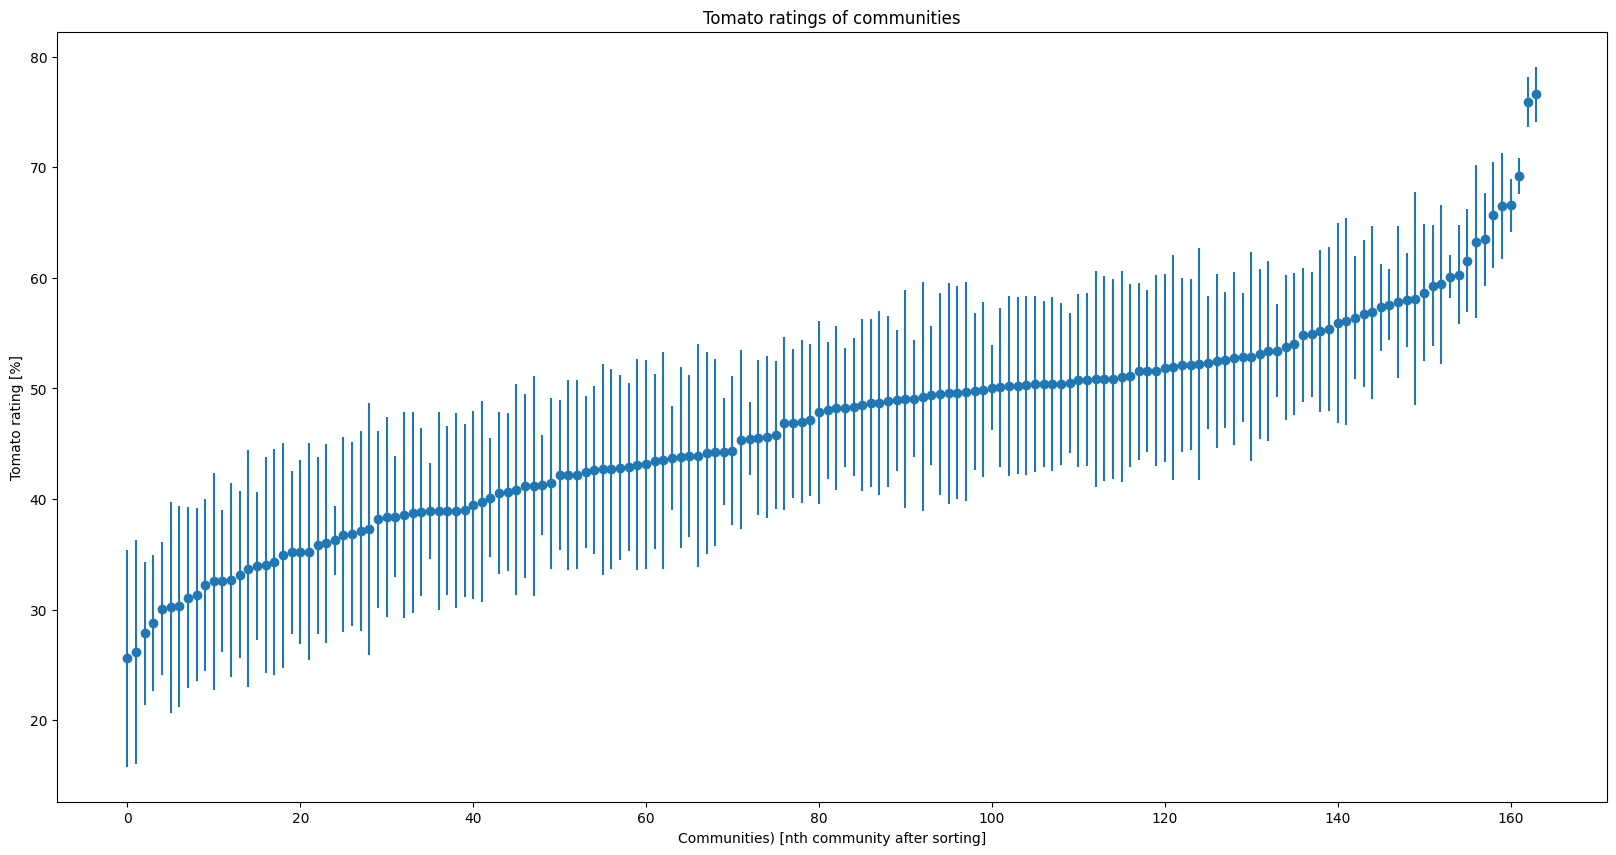

In [24]:
#sort dicts
audience_ratings_dict = dict(sorted(audience_ratings_dict.items(), key=lambda item: item[1][0]))
tomato_ratings_dict = dict(sorted(tomato_ratings_dict.items(), key=lambda item: item[1][0]))

#plot tomato ratings
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(tomato_ratings_dict)),
[x[0] for x in tomato_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in tomato_ratings_dict.values()],
fmt='o')
plt.title("Tomato ratings of communities")
plt.xlabel("Communities) [nth community after sorting]")
plt.ylabel("Tomato rating [%]")
plt.show()

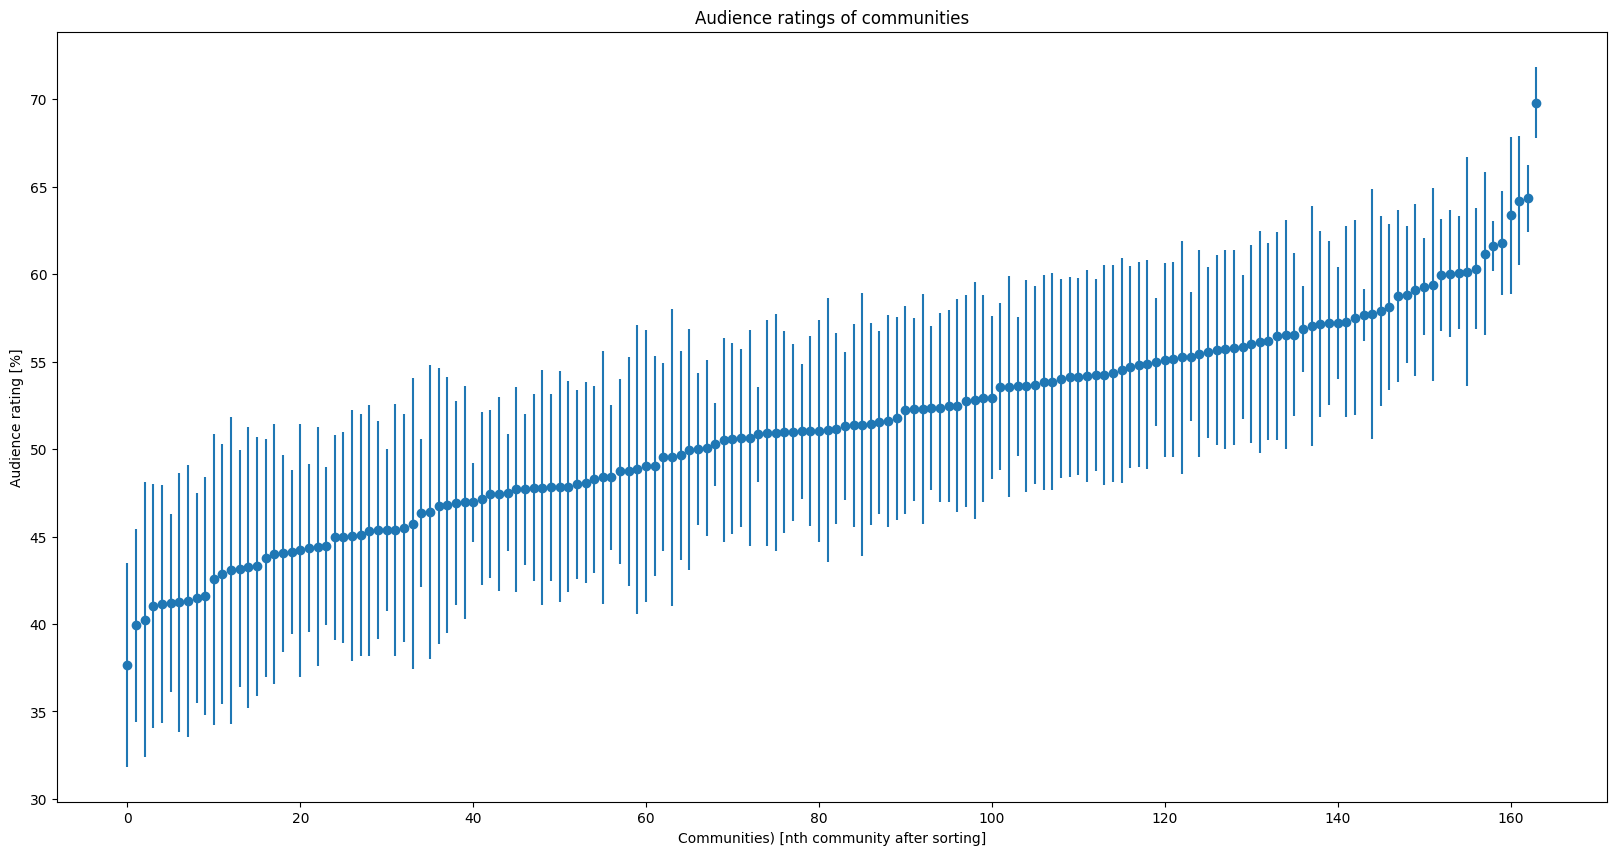

In [25]:
#plot audience ratings
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(audience_ratings_dict)),
[x[0] for x in audience_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in audience_ratings_dict.values()],
fmt='o')
plt.title("Audience ratings of communities")
plt.xlabel("Communities) [nth community after sorting]")
plt.ylabel("Audience rating [%]")
plt.show()

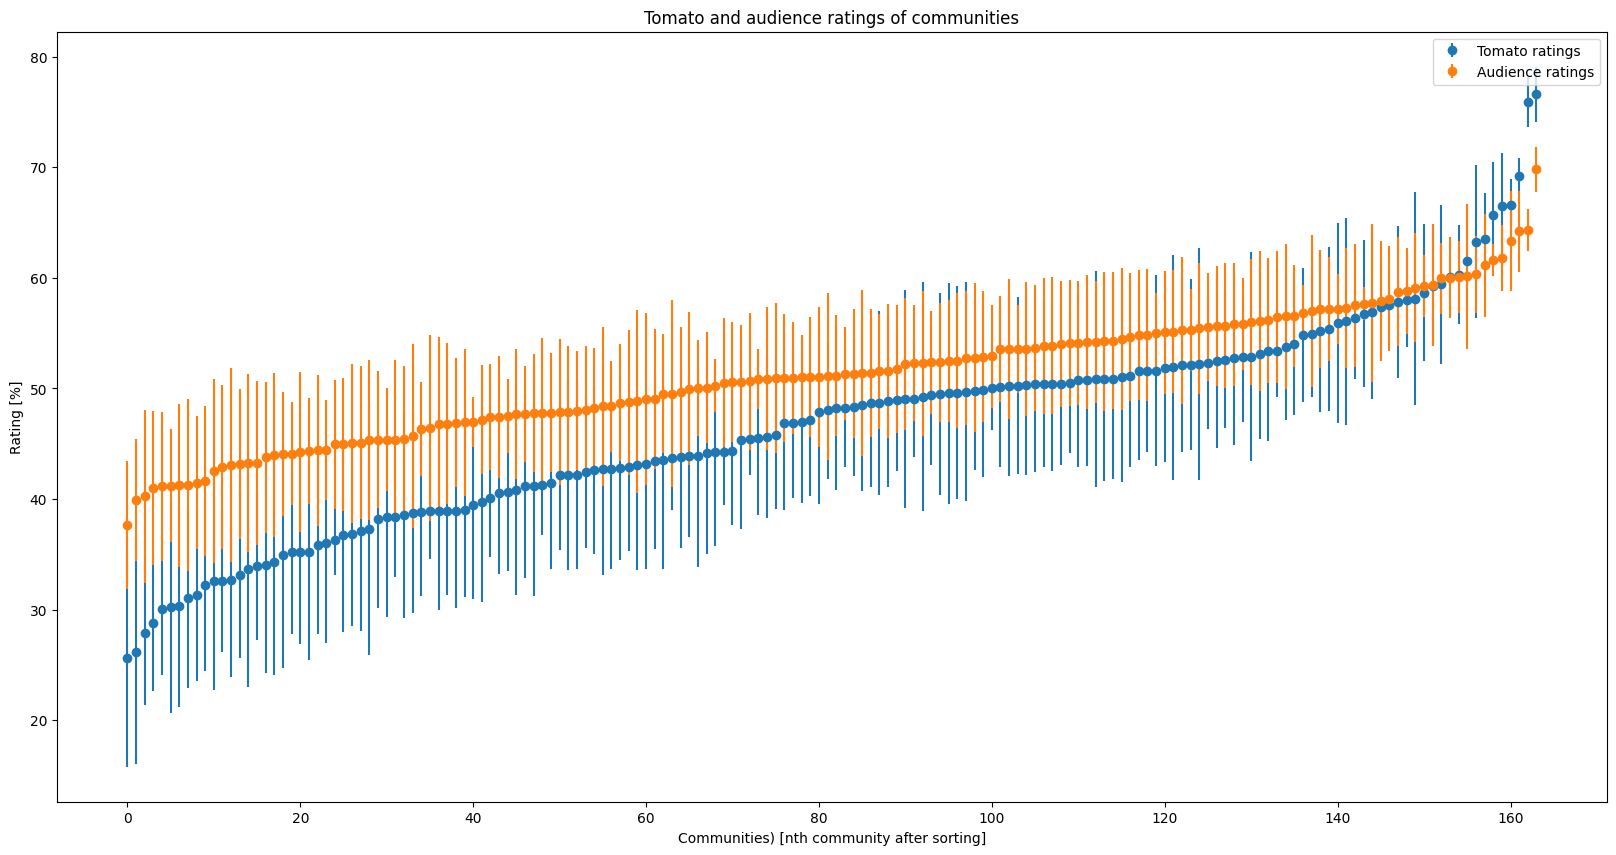

In [26]:
#contrast tomato and audience ratings
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(tomato_ratings_dict)),
[x[0] for x in tomato_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in tomato_ratings_dict.values()],
fmt='o', label="Tomato ratings")
plt.errorbar(range(len(audience_ratings_dict)),
[x[0] for x in audience_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in audience_ratings_dict.values()],
fmt='o', label="Audience ratings")
plt.title("Tomato and audience ratings of communities")
plt.xlabel("Communities) [nth community after sorting]")
plt.ylabel("Rating [%]")
plt.legend()
plt.show()


In [27]:
#find highest rated community
highest_tomato = max(tomato_ratings_dict, key=tomato_ratings_dict.get)
highest_audience = max(audience_ratings_dict, key=audience_ratings_dict.get)
print("Highest rated community by tomato rating: " + str(highest_tomato))
print("Highest rated community by audience rating: " + str(highest_audience))
#find lowest rated community
lowest_tomato = min(tomato_ratings_dict, key=tomato_ratings_dict.get)
lowest_audience = min(audience_ratings_dict, key=audience_ratings_dict.get)
print("Lowest rated community by tomato rating: " + str(lowest_tomato))
print("Lowest rated community by audience rating: " + str(lowest_audience))

Highest rated community by tomato rating: 233
Highest rated community by audience rating: 55
Lowest rated community by tomato rating: 204
Lowest rated community by audience rating: 204


In [28]:
print(tomato_ratings_dict[highest_tomato],
 audience_ratings_dict[highest_audience], 
 tomato_ratings_dict[lowest_tomato], 
 audience_ratings_dict[lowest_audience], sep="\n")

[76.60089076956092, 81.60060176775252]
[69.81351404413438, 73.9097563961172]
[25.61065497151082, 45.24648788563204]
[37.66227210993428, 49.3091564614943]


In [29]:
#double check sample size
count[highest_tomato], count[highest_audience], count[lowest_tomato], count[lowest_audience]

(268, 318, 35, 35)

not too happy because of the tendency, big community>great rating, small community>bad rating...
however these aren't the biggest nor smallest ones, so I think it is acceptable

In [30]:
#export highest_tomato, highest_audience, lowest_tomato, lowest_audience from newdict to csv
with open('highest_tomato.csv', 'w') as f:
    for key in newdict[highest_tomato]:
        f.write("%s\n" % key)
with open('highest_audience.csv', 'w') as f:
    for key in newdict[highest_audience]:
        f.write("%s\n" % key)
with open('lowest_tomato.csv', 'w') as f:
    for key in newdict[lowest_tomato]:
        f.write("%s\n" % key)
with open('lowest_audience.csv', 'w') as f:
    for key in newdict[lowest_audience]:
        f.write("%s\n" % key)

note: looking at the actual movies, there are some outliers.
the cause could be interesting...

now have a look at the grouping by genre and rating

In [43]:
#create dict, key is rating and value is list of movies with that rating
#we will use the filtered dict, to work with the same data
rating_dict = {}
rating_list = []
for item in G.nodes:
    rating_dict[item] = G.nodes[item]['content_rating']
    if G.nodes[item]['content_rating'] not in rating_list:
        rating_list.append(G.nodes[item]['content_rating'])

In [45]:
#add all movies to communities
movies_dict_byrating = {}
for i in rating_list:
    movielist = []
    for key, value in rating_dict.items():
        if value == i:
            movielist.append(key)
    movies_dict_byrating[i] = movielist

In [48]:
#export movies_dict_byrating to csv
for key, value in movies_dict_byrating.items():
    with open(key + '.csv', 'w') as f:
        for item in value:
            f.write("%s\n" % item)

communities by genre

In [83]:
#create dict, key is genre and value is list of movies with that genre
#we will use the filtered dict, to work with the same data
genre_dict = {}
genre_list = []
for item in G.nodes:
    genre_dict[item] = G.nodes[item]['genre']
    if G.nodes[item]['genre'] not in genre_list:
        genre_list.append(G.nodes[item]['genre'])

In [84]:
#add all movies to communities
movies_dict_bygenre = {}
for i in genre_list:
    movielist = []
    for key, value in genre_dict.items():
        if value == i:
            movielist.append(key)
    movies_dict_bygenre[i] = movielist

In [86]:
#store genres with less than 3 movies in a list
weirdgenres = []
for key, value in movies_dict_bygenre.items():
    if len(value) < 3:
        weirdgenres.append(key)

In [98]:
#unify too unique genres
keys_to_delete = []
weirdlist = []
for key, value in movies_dict_bygenre.items():
    if key in weirdgenres:
        for item in value:
            weirdlist.append(item)
        keys_to_delete.append(key)

for i in keys_to_delete:
    del movies_dict_bygenre[i]

movies_dict_bygenre['Mixed'] = weirdlist

VISUALIZATION TESTING

In [ ]:
#iterate through G and copy common nodes to new graph add edges
G2 = nx.Graph()
for node in G.nodes():
    if node in mydict:
        G2.add_node(node, group=mydict[node])
        for neighbor in G.neighbors(node):
            if neighbor in mydict:
                G2.add_node(neighbor, group=mydict[neighbor])
                G2.add_edge(node, neighbor)

In [ ]:
H = nx.Graph()
iterator = 0
for item in mydict:
    H.add_node(list(mydict.keys())[iterator], group = list(mydict.values())[iterator])
    iterator += 1

In [ ]:
H.nodes.data()

In [ ]:
nx.write_gexf(G2, "test.gexf")